In [1]:
import numpy as np
from k_local import build_local
import itertools

Q = np.array([
        [2,1],
        [1,2]
    ])

## Criação da discretização 2D, numeração dos nós e numeração dos elementos

In [2]:
nx = 40
ny = 40
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))

In [3]:
print(X.shape, Y.shape)

(40, 40) (40, 40)


In [4]:
Z = np.array(list(zip(X.ravel(), Y.ravel())))
print(Z.shape)

(1600, 2)


In [5]:
nodes = list(enumerate(Z))
nodes_n = nodes[-1][0] + 1
print(nodes_n)

1600


In [6]:
elements_n = (nx-1)*(ny-1)
print(elements_n)

1521


In [7]:
G = np.zeros((4,elements_n), dtype=np.int64)

In [8]:
num = 0

for d in range(ny-1):
    for i in range((nx-1)):
        G[:,num] = np.array([i+d*nx, i+1+d*nx, i+nx+1+d*nx, i+nx+d*nx])
        num+=1
        
# for x in range(G.shape[1]):
#     print(G[:,x])

## Montagem da matriz rigidez local, e posterior mapeamento para a matriz rigidez global

In [9]:
def map_nodes_to_physical(G, elem, verbose=False):
    n_ = G[:,elem]
    l = list()
    
    for idx in n_:
        l.append(nodes[int(idx)][1])
        if verbose:
            print('global node {0} --> point {1} on R2'.format(idx, nodes[int(idx)][1]))
        
    M = np.array(l).T
    return M

In [10]:
def l2g(EQ_vector, L2G_matrix, Q_ab, f, prescribed, verbose=False):
    #L2G_matrix sera o n_
    nodes_per_elem, elem_n = L2G_matrix.shape
    
    if verbose:
        print(nodes_per_elem, elem_n)
    
    eq_n = int(np.max(EQ_vector) + 1)
    
    if verbose:
        print(eq_n)
    
    K = np.zeros((eq_n, eq_n))
    F = np.zeros((eq_n, ))
    
    for elem in range(elem_n):
        global_nodes = L2G_matrix[:,elem]
        f_on_nodes = f[global_nodes]
        pres_on_nodes = prescribed[global_nodes]
        
        if verbose:
            print('global nodes --> {0}'.format(global_nodes))
            print('f on nodes --> {0}'.format(f_on_nodes))
            print('prescribed on nodes --> {0}'.format(pres_on_nodes))
            
        c = itertools.product(range(nodes_per_elem),repeat=2)
        M = map_nodes_to_physical(L2G_matrix, elem, verbose=verbose)
        local_k, local_F = build_local(M, Q, Q_ab, f_on_nodes, pres_on_nodes)
        
        for x in c:
            aux1 = L2G_matrix[x[0]][elem]
            aux2 = L2G_matrix[x[1]][elem]    
            i = EQ_vector[aux1]
            j = EQ_vector[aux2]
            
            if verbose:
                print('el_node {0} --> glob_node {1} --> eq_vec {2}'.format((x), (aux1, aux2), (i, j)))
                
            if i != -1 and j != -1:
                K[i][j] += local_k[x[0]][x[1]]
                
                if verbose:
                    print('\t----> accumulating to global')
        
        for node in global_nodes:
            i = EQ_vector[node]
            
            if verbose:
                print('node {0} --> equation {1}'.format(node, i))
                
            if i != -1:
                
                if verbose:
                    print('\tnode {0} --> pos {1} on local_f'.format(node, np.where(global_nodes == node)[0]))
                
                F[i] += local_F[np.where(global_nodes == node)[0]]
        
        if verbose:
            print('+'*60)

    return K, F

In [11]:
phi_1 = lambda ksi, eta: 0.25*(1-ksi)*(1-eta)
phi_2 = lambda ksi, eta: 0.25*(1+ksi)*(1-eta)
phi_3 = lambda ksi, eta: 0.25*(1+ksi)*(1+eta)
phi_4 = lambda ksi, eta: 0.25*(1-ksi)*(1+eta)

gauss_points = [[-np.sqrt(3)/3,-np.sqrt(3)/3],
                [np.sqrt(3)/3, -np.sqrt(3)/3],
                [np.sqrt(3)/3, np.sqrt(3)/3],
                [-np.sqrt(3)/3, np.sqrt(3)/3]]

interp = np.array([phi_1, phi_2, phi_3, phi_4])

Q_ab = np.zeros((4,4))

verbose = False
for i in range(4):
    for j in range(4):
        for pg in gauss_points:
            Q_ab[i, j] += interp[i](pg[0], pg[1])*interp[j](pg[0], pg[1])
            
            if verbose:
                print('({0}, {1}) --> pg = ({2}, {3})'.format(i, j, pg[0], pg[1]))
        
        if verbose:
            print('+'*60)

In [12]:
f_ = lambda x: (2*np.pi**2)*(2*np.sin(np.pi*x[0])*np.cos(np.pi*x[1]) + np.cos(np.pi*x[0])*np.sin(np.pi*x[1]))
f = np.zeros((nodes_n,))
for pts in nodes:
    f[pts[0]] = f_(pts[1])

In [13]:
# print(f)

In [14]:
prescribed = np.zeros((nodes_n, ))

gamma_1 = np.where(Z[:,1] == 0)[0]
# print('gamma_1 {0}'.format(gamma_1))
prescribed[gamma_1] = np.sin(np.pi*Z[gamma_1,0])

gamma_2 = np.where(Z[:,0] == 1)[0]
# print('gamma_2 {0}'.format(gamma_2))

gamma_3 = np.where(Z[:,1] == 1)[0]
# print('gamma_3 {0}'.format(gamma_3))
prescribed[gamma_3] = -np.sin(np.pi*Z[gamma_3,0])
gamma_4 = np.where(Z[:,0] == 0)[0]
# print('gamma_4 {0}'.format(gamma_4))

# print('prescribed {0}'.format(prescribed))

In [15]:
known_sols = np.concatenate((gamma_1, gamma_2, gamma_3, gamma_4),axis=0)

d_sols = np.setdiff1d(np.arange(nodes_n), known_sols)

In [16]:
EQ_vector = np.zeros((nodes_n,), dtype=np.int64) - 1
count = 0

for idx in range(EQ_vector.shape[0]):
    if idx in d_sols:
        EQ_vector[idx] = count
        count += 1

In [17]:
K, F = l2g(EQ_vector, G, Q_ab, f, prescribed, verbose=False)

In [18]:
d = np.linalg.solve(K, F)

In [19]:
sols = prescribed
sols[d_sols] = d

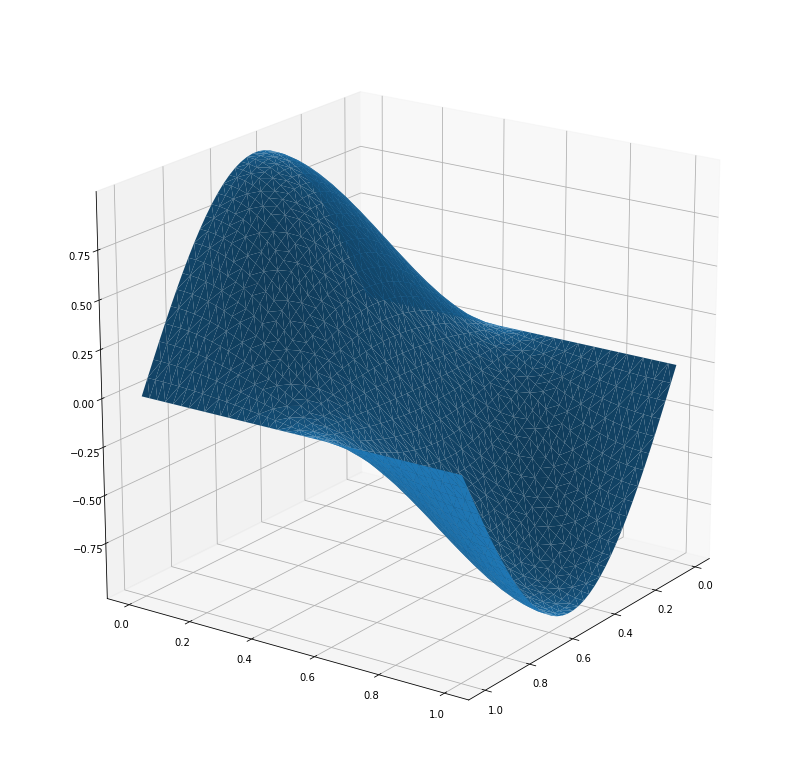

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

X, Y = Z[:,0], Z[:,1]

ax.plot_trisurf(X, Y, sols)
ax.view_init(20,35)
plt.show()